In [139]:
import json
import glob
import datetime
import os

import matplotlib.pyplot as plt

In [140]:
output_path = "logs"

In [141]:
log_paths = glob.glob("logs\\*.json")

logs = []
for log_path in log_paths:
    with open(log_path) as file:
        logs.append(json.load(file))

In [142]:
logs = sorted(logs, key=lambda log : log["agent_time"])

In [143]:
times = []
sound_intensities = []

for log in logs:
    if "sound_intensity" not in log["sensor_result"]:
        continue

    agent_time = datetime.datetime.fromtimestamp(log["agent_time"])
    hour_time = 0
    hour_time += agent_time.hour
    hour_time += agent_time.minute/60
    hour_time += agent_time.second/60/60
        
    times.append(hour_time)
    sound_intensities.append(log["sensor_result"]["sound_intensity"])

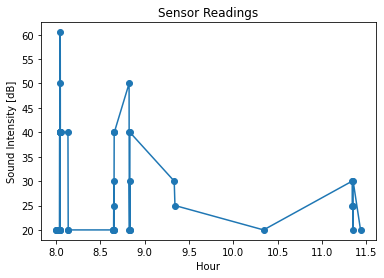

In [144]:
fig = plt.figure()
plt.plot(times, sound_intensities, "o-")

plt.title("Sensor Readings")
plt.xlabel("Hour")
plt.ylabel("Sound Intensity [dB]")

path = os.path.join(output_path, "SensorReadings.png")
fig.savefig(path, facecolor="white", transparent=False)

plt.show()

In [152]:
for log in logs:
    agent_time = datetime.datetime.fromtimestamp(log["agent_time"])
    print(agent_time.strftime("%H:%M:%S"), log["current_place"])
    print()

    if "sound_intensity" in log["sensor_result"]:
        print("Sensor reading:", log["sensor_result"]["sound_intensity"], "dB")
    else:
        print("Sensor reading:")
    print()

    print("State:", log["state"])
    print()
    print("Observation:", log["curret_observation"])
    print()
    print("Next action:", log["action"])
    print()
    print("----")

08:00:00 Bedroom

Sensor reading:

State: 

Observation: 

Next action: Alex wakes up

----
08:00:01 Bedroom

Sensor reading: 20.0 dB

State: awake

Observation: He finds himself in his bedroom, lying on his cozy bed, surrounded by his dresser, nightstand, and closet. He notices his notebook and pens on the desk, and his nature photographs hung on the walls. He feels the softness of his bed and the gentle morning light coming through the window. He hears the silence of his home, only broken by the quiet hum of the refrigerator in the kitchen. He notices the slight mess on his bed and the smell of his clean laundry coming from the dresser. He feels refreshed and awake, ready to start his day.

Next action: Alex gets out of bed

----
08:00:03 Bedroom

Sensor reading: 20.0 dB

State: standing

Observation: He is in his bedroom, standing up after getting out of his unoccupied and messy bed. He sees his dresser with neatly organized clothes, nightstand with a lamp and a few personal items, 

In [146]:
for action in logs[0]["plan"]:
    hour = action["hour"]
    minute = action["minute"]
    action_action = action["action"]

    print(f"{hour}:{minute}: {action_action}")


8:0: Wake up
8:15: Have breakfast
9:0: Get computer and necessary cables ready for editing
9:10: Organize and import yesterday's photos to editing software
9:30: Start editing photos
12:0: Lunch break
13:0: Respond to social media comments
13:20: Post new content
15:0: Continue editing photos
15:10: Continue editing photos
15:20: Continue editing photos
15:30: Continue editing photos
15:40: Continue editing photos
15:50: Continue editing photos
18:0: Take a break
18:10: Read a book
18:30: Have a snack
20:0: Meditate
20:10: Reflect on the day
21:0: Write in journal
22:0: Start winding down
22:10: Begin nighttime routine
22:20: Get into bed


In [149]:
print("First log time")
print(datetime.datetime.fromtimestamp(os.path.getctime(log_paths[0])))
print("Last log time")
print(datetime.datetime.fromtimestamp(os.path.getctime(log_paths[-1])))

First log time
2024-06-27 13:26:23.358463
Last log time
2024-06-27 14:59:41.325822


In [151]:
len(log_paths)

47